In [4]:
# ==========================================================
# 1. Load Dataset
# ==========================================================
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from kagglehub import dataset_download

path = dataset_download("ealaxi/paysim1")
csv_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
data = pd.read_csv(csv_path)

c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


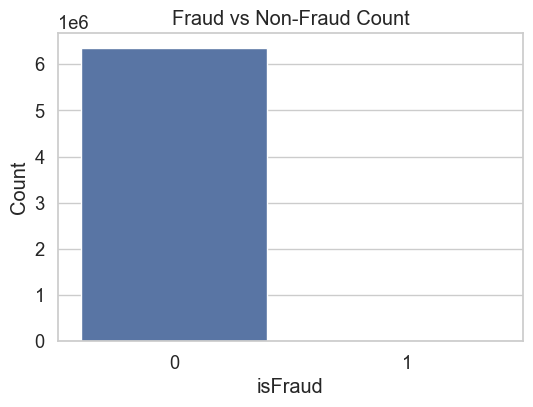

Fraud Ratio: 0.001291 (0.1291%)


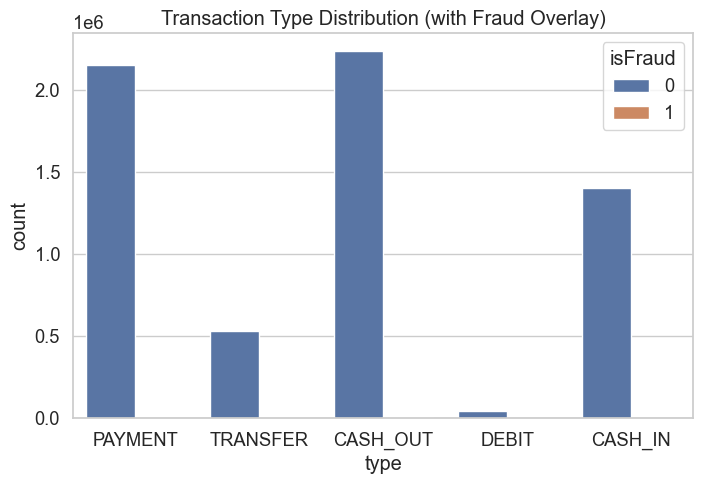

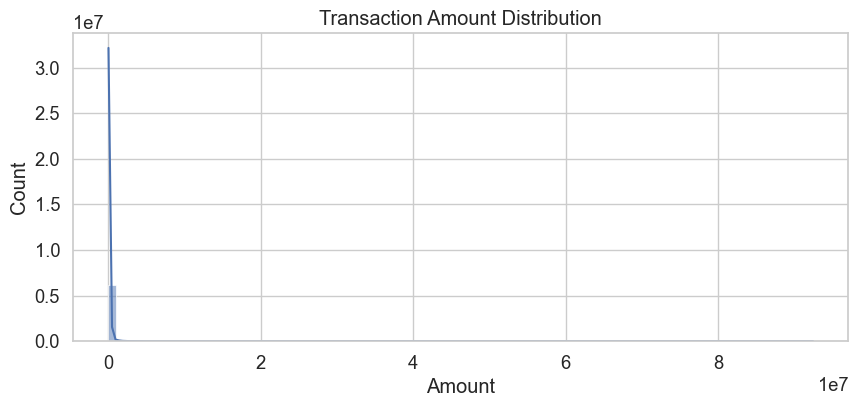

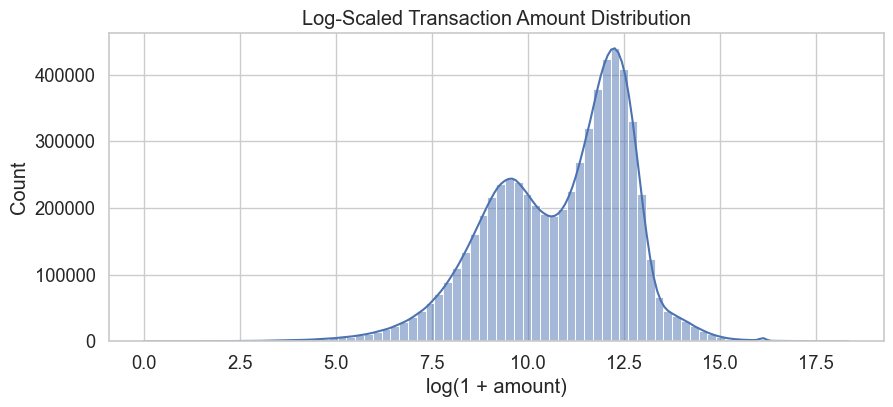

c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Kwek Jie Han\AppData\Local\Temp\ipykernel_24632\3507010511.py:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x='amount', hue='isFraud', log_scale=True)


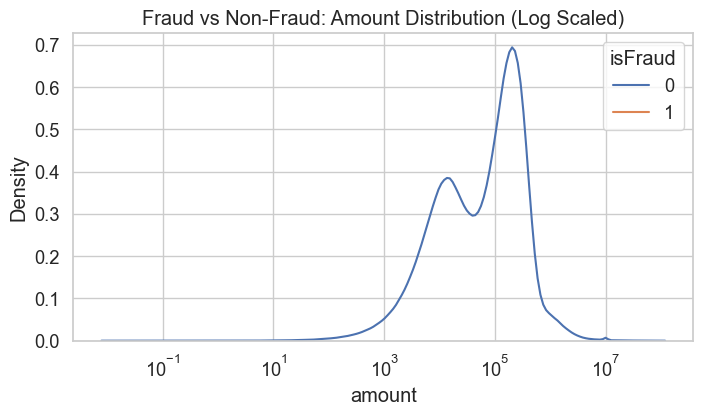

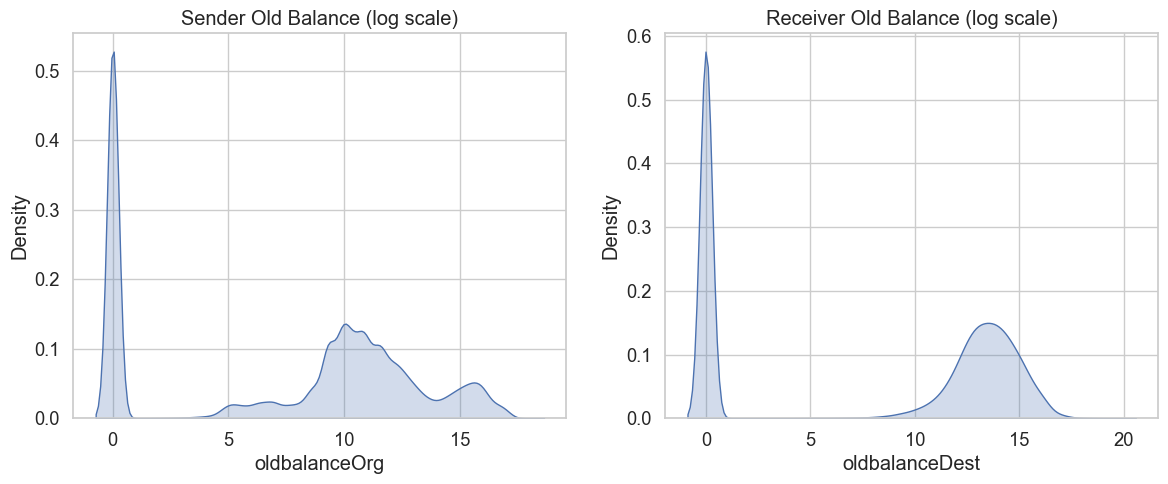

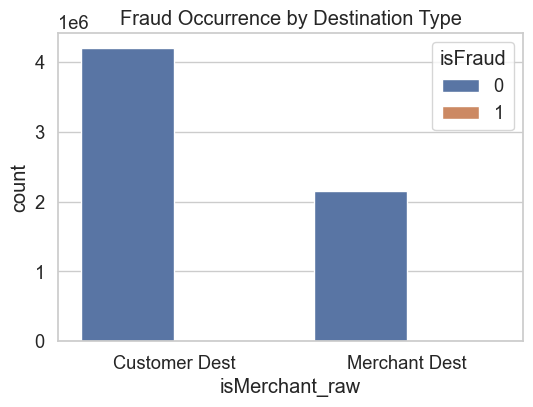

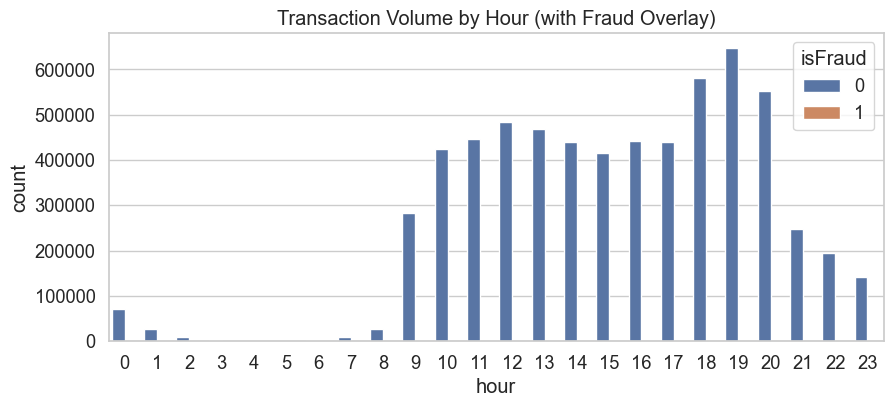

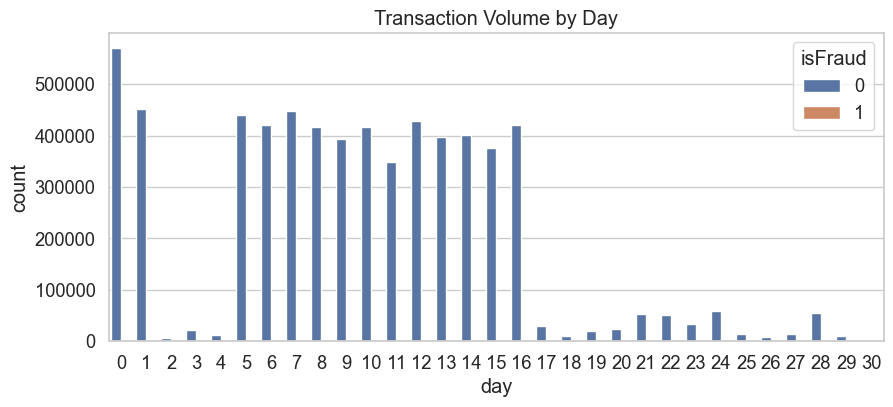

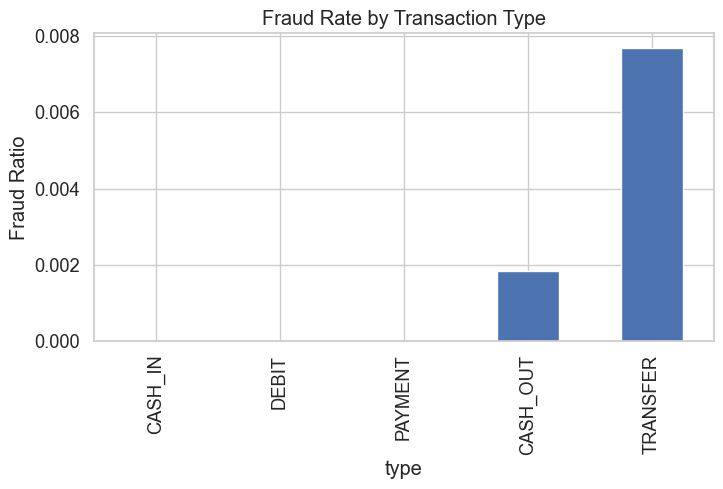

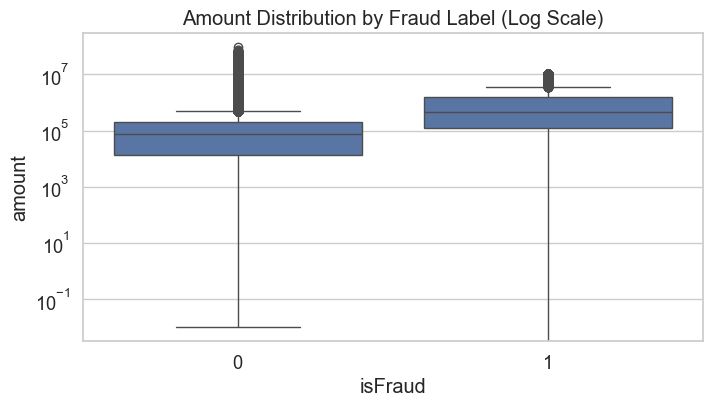

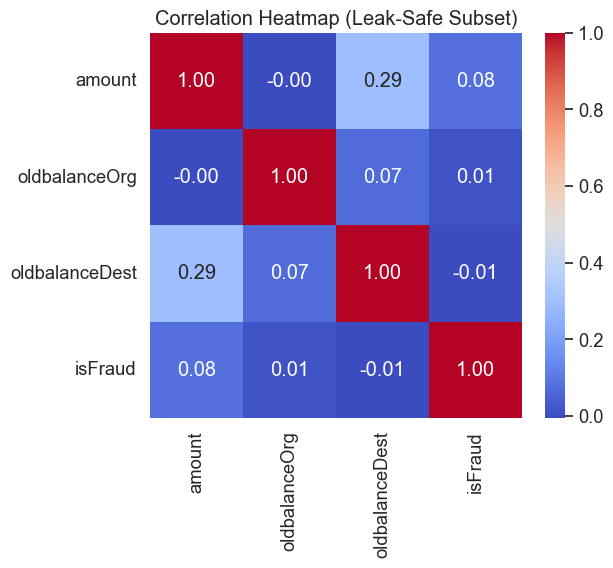

C:\Users\Kwek Jie Han\AppData\Local\Temp\ipykernel_24632\3507010511.py:147: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Non-Zero", "Zero"])
C:\Users\Kwek Jie Han\AppData\Local\Temp\ipykernel_24632\3507010511.py:151: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Non-Zero", "Zero"])


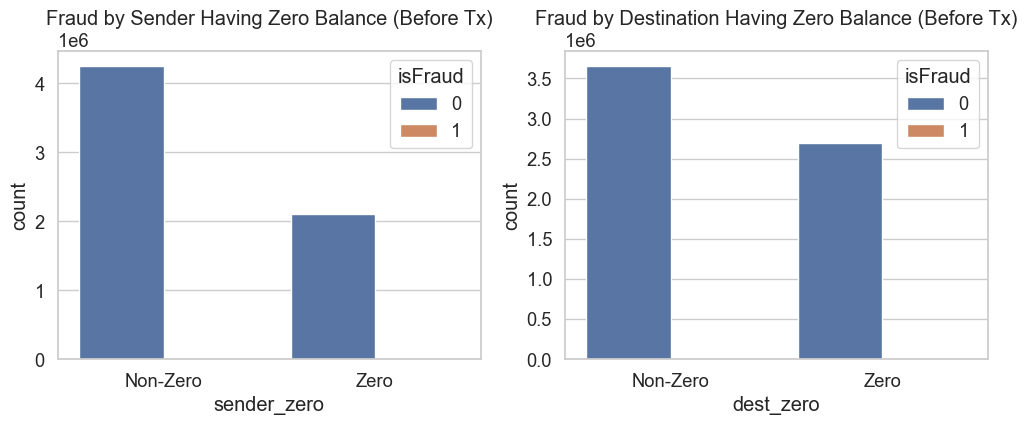

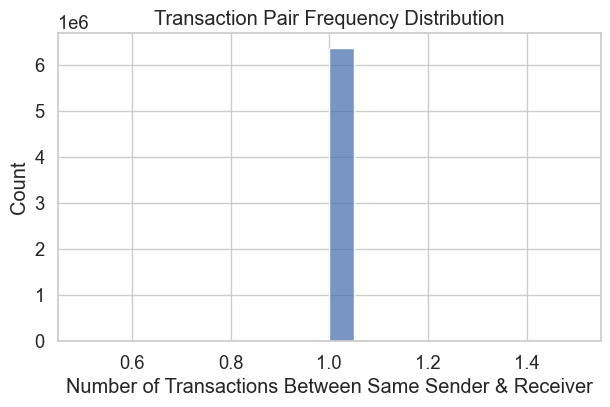

In [5]:
# ==========================================================
# 1.5 Exploratory Data Analysis (EDA)
# ==========================================================
sns.set(style="whitegrid", font_scale=1.2)

# -----------------------------
# 1. Fraud Class Imbalance
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='isFraud')
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

fraud_ratio = data['isFraud'].mean()
print(f"Fraud Ratio: {fraud_ratio:.6f} ({fraud_ratio*100:.4f}%)")

# -----------------------------
# 2. Transaction Types
# -----------------------------
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='type', hue='isFraud')
plt.title("Transaction Type Distribution (with Fraud Overlay)")
plt.show()

# -----------------------------
# 3. Transaction Amount Distribution
# -----------------------------
plt.figure(figsize=(10,4))
sns.histplot(data['amount'], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.show()

# Log-scale plot for skewed distribution
plt.figure(figsize=(10,4))
sns.histplot(np.log1p(data['amount']), bins=80, kde=True)
plt.title("Log-Scaled Transaction Amount Distribution")
plt.xlabel("log(1 + amount)")
plt.show()

# -----------------------------
# 4. Fraud Amount Distribution
# -----------------------------
plt.figure(figsize=(8,4))
sns.kdeplot(data=data, x='amount', hue='isFraud', log_scale=True)
plt.title("Fraud vs Non-Fraud: Amount Distribution (Log Scaled)")
plt.show()

# -----------------------------
# 5. Balance Behaviour
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=np.log1p(data['oldbalanceOrg']), ax=axes[0], fill=True)
axes[0].set_title("Sender Old Balance (log scale)")

sns.kdeplot(data=np.log1p(data['oldbalanceDest']), ax=axes[1], fill=True)
axes[1].set_title("Receiver Old Balance (log scale)")

plt.show()

# -----------------------------
# 6. Merchant vs Customer Destinations
# -----------------------------
data['isMerchant_raw'] = data['nameDest'].str.startswith("M").astype(int)

plt.figure(figsize=(6,4))
sns.countplot(x=data['isMerchant_raw'], hue=data['isFraud'])
plt.xticks([0,1], ["Customer Dest", "Merchant Dest"])
plt.title("Fraud Occurrence by Destination Type")
plt.show()

# -----------------------------
# 7. Temporal Patterns: Hour of Day
# -----------------------------
hour = data['step'] % 24
data['hour'] = hour

plt.figure(figsize=(10,4))
sns.countplot(x='hour', data=data, hue='isFraud')
plt.title("Transaction Volume by Hour (with Fraud Overlay)")
plt.show()

# -----------------------------
# 8. Temporal Patterns: Days
# -----------------------------
data['day'] = data['step'] // 24

plt.figure(figsize=(10,4))
sns.countplot(x='day', data=data, hue='isFraud')
plt.title("Transaction Volume by Day")
plt.show()

# -----------------------------
# 9. Fraud Rate by Transaction Type
# -----------------------------
fraud_rate_type = data.groupby('type')['isFraud'].mean()

plt.figure(figsize=(8,4))
fraud_rate_type.sort_values().plot(kind='bar')
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Ratio")
plt.show()

# -----------------------------
# 10. Boxplots: Fraud vs Non-Fraud (Amount)
# -----------------------------
plt.figure(figsize=(8,4))
sns.boxplot(data=data, x='isFraud', y='amount')
plt.yscale('log')
plt.title("Amount Distribution by Fraud Label (Log Scale)")
plt.show()

# -----------------------------
# 11. Correlation Heatmap (only safe numeric features)
# -----------------------------
safe_numeric_cols = [
    'amount',
    'oldbalanceOrg',
    'oldbalanceDest',
    'isFraud',
]

corr = data[safe_numeric_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Leak-Safe Subset)")
plt.show()

# -----------------------------
# 12. Fraud Occurrence by Sender/Receiver Zero-Balance
# -----------------------------
data['sender_zero'] = (data['oldbalanceOrg'] == 0).astype(int)
data['dest_zero'] = (data['oldbalanceDest'] == 0).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(x='sender_zero', hue='isFraud', data=data, ax=axes[0])
axes[0].set_title("Fraud by Sender Having Zero Balance (Before Tx)")
axes[0].set_xticklabels(["Non-Zero", "Zero"])

sns.countplot(x='dest_zero', hue='isFraud', data=data, ax=axes[1])
axes[1].set_title("Fraud by Destination Having Zero Balance (Before Tx)")
axes[1].set_xticklabels(["Non-Zero", "Zero"])

plt.show()

# -----------------------------
# 13. Fraud by Transaction Pair Frequency
# -----------------------------
pair_freq = data.groupby(['nameOrig','nameDest']).size().clip(upper=20)

plt.figure(figsize=(7,4))
sns.histplot(pair_freq, bins=20)
plt.title("Transaction Pair Frequency Distribution")
plt.xlabel("Number of Transactions Between Same Sender & Receiver")
plt.show()



In [36]:
# ==========================================================
# 2. Feature Engineering (Leak-Safe)
# ==========================================================
data['deltaOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['deltaDest'] = data['newbalanceDest'] - data['oldbalanceDest']
data['amt_mean_by_type'] = data.groupby('type')['amount'].transform('mean')
data['amt_std_by_type'] = data.groupby('type')['amount'].transform('std')
data['amount_zscore_by_type'] = (data['amount'] - data['amt_mean_by_type']) / (data['amt_std_by_type'] + 1e-6)
data['amt_to_balance_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1e-6)
data['cum_amt_sent'] = data.groupby('nameOrig')['amount'].cumsum()
data['cum_tx_count'] = data.groupby('nameOrig').cumcount() + 1
data['avg_amt_so_far'] = data['cum_amt_sent'] / data['cum_tx_count']
data['isMerchant'] = data['nameDest'].str.startswith('M').astype('int8')
data['is_zero_balance'] = (data['oldbalanceOrg'] == 0).astype('int8')
data['is_new_dest'] = (data['oldbalanceDest'] == 0).astype('int8')
data['same_balance_flag'] = (data['oldbalanceOrg'] == data['newbalanceOrig']).astype('int8')
data['pair_transaction_count'] = data.groupby(['nameOrig','nameDest']).cumcount()
data['is_repeated_pair'] = (data['pair_transaction_count'] > 0).astype('int8')
data['hour'] = data['step'] % 24

def time_bin(h):
    if h < 6: return 'Night'
    elif h < 12: return 'Morning'
    elif h < 18: return 'Afternoon'
    return 'Evening'
data['time_bin'] = data['hour'].apply(time_bin)

data['day'] = data['step'] // 24
data['day_of_week'] = data['day'] % 7
day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
data['day_name'] = data['day_of_week'].map(day_map)
data['near_flag_limit'] = ((data['amount'] > 150000) & (data['amount'] <= 200000)).astype('int8')

data.sort_values(['nameOrig','step'], inplace=True)
data['tx_count_last_24h'] = data.groupby('nameOrig')['step'].rolling(24).count().shift(1).reset_index(0,drop=True)
data['amt_avg_last_24h'] = data.groupby('nameOrig')['amount'].rolling(24).mean().shift(1).reset_index(0,drop=True)
data['time_since_last_tx'] = data.groupby('nameOrig')['step'].diff().fillna(0)

In [37]:
# ==========================================================
# 3. Leak-Safe Feature Selection
# ==========================================================
TARGET = 'isFraud'
DROP_COLS = [
    'nameOrig','nameDest','isFlaggedFraud',
    'newbalanceOrig','newbalanceDest',
    'deltaOrig','deltaDest',
    'sender_balance_change_ratio','receiver_balance_change_ratio',
    'same_balance_flag'
]
data[TARGET] = data[TARGET].astype('int8')

for c in data.columns:
    if data[c].dtype == 'float64':
        data[c] = data[c].astype('float32')

leak_features = [
    'newbalanceOrig', 'newbalanceDest',
    'deltaOrig', 'deltaDest',
    'sender_balance_change_ratio', 'receiver_balance_change_ratio',
    'same_balance_flag'
]
data.drop(columns=[c for c in leak_features if c in data.columns], inplace=True)

feature_cols = [c for c in data.columns if c not in DROP_COLS + [TARGET]]

In [38]:
# ==========================================================
# 4. Account-Level Split (Prevents Leakage)
# ==========================================================
from sklearn.model_selection import train_test_split

unique_accounts = data['nameOrig'].unique()
train_accounts = np.random.choice(unique_accounts, int(len(unique_accounts) * 0.85), replace=False)

train_idx = data['nameOrig'].isin(train_accounts)
valid_idx = ~data['nameOrig'].isin(train_accounts)

X_train, X_valid = data.loc[train_idx, feature_cols].copy(), data.loc[valid_idx, feature_cols].copy()
y_train, y_valid = data.loc[train_idx, TARGET], data.loc[valid_idx, TARGET]

cat_cols = [c for c in ['type', 'time_bin', 'day_name', 'day_of_week'] if c in feature_cols]
for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_valid[c] = X_valid[c].astype('category')

In [39]:
# ==========================================================
# 5. Model Training Section
# ==========================================================
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

results = []

In [40]:
# ----------------------------------------------------------
# LightGBM (Safe)
# ----------------------------------------------------------
pos, neg = y_train.sum(), (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=5000, learning_rate=0.03,
    num_leaves=63, subsample=0.8,
    colsample_bytree=0.8, reg_alpha=1.0,
    reg_lambda=2.0, scale_pos_weight=scale_pos_weight,
    n_jobs=4, random_state=42
)
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    categorical_feature=cat_cols,
    callbacks=[early_stopping(300), log_evaluation(50)],
)
pred_lgb = lgbm.predict_proba(X_valid)[:, 1]
results.append(("LightGBM-Safe", roc_auc_score(y_valid, pred_lgb), average_precision_score(y_valid, pred_lgb)))

[LightGBM] [Info] Number of positive: 6995, number of negative: 5401203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 5408198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001293 -> initscore=-6.649181
[LightGBM] [Info] Start training from score -6.649181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 300 rounds
[50]	valid_0's binary_logloss: 0.0972306
[100]	valid_0's binary_logloss: 0.066331
[150]	valid_0's binary_logloss: 0.0513581
[200]	valid_0's binary_logloss: 0.0401323
[250]	valid_0's binary_logloss: 0.0346037
[300]	valid_0's binary_logloss: 0.0316153
Early stopping, best iteration is:
[2]	valid_0's bin

In [41]:
# ----------------------------------------------------------
# LightGBM (Strict)
# ----------------------------------------------------------
strict_feats = [c for c in feature_cols if not any(x in c for x in
    ['delta','balance','_ratio','same_balance','is_zero_balance','is_new_dest'])]

lgbm_strict = LGBMClassifier(
    objective='binary', eval_metric='auc',
    n_estimators=5000, learning_rate=0.03,
    num_leaves=63, subsample=0.8,
    colsample_bytree=0.8, reg_alpha=1.0,
    reg_lambda=2.0, scale_pos_weight=scale_pos_weight,
    n_jobs=4, random_state=42
)
lgbm_strict.fit(
    X_train[strict_feats], y_train,
    eval_set=[(X_valid[strict_feats], y_valid)],
    categorical_feature=[c for c in cat_cols if c in strict_feats],
    callbacks=[early_stopping(300), log_evaluation(50)],
)
pred_lgb_strict = lgbm_strict.predict_proba(X_valid[strict_feats])[:, 1]
results.append(("LightGBM-Strict", roc_auc_score(y_valid, pred_lgb_strict), average_precision_score(y_valid, pred_lgb_strict)))



[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 6995, number of negative: 5401203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 5408198, number of used features: 19
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001293 -> initscore=-6.649181
[LightGBM] [Info] Start training from score -6.649181
Training until validation scores don't improve for 300 rounds
[50]	valid_0's binary_logloss: 1.9058
[100]	valid_0's binary_logloss: 1.75854
[150]	valid_0's binary_logloss: 1.613
[200]	valid_0's binary_logloss: 1.54569
[250]	valid_0's binary_logloss: 1.49744
[300]	valid_0's binary_lo

In [ ]:
# ----------------------------------------------------------
# XGBoost (with categorical handling)
# ----------------------------------------------------------
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_valid[c] = X_valid[c].astype("category")

xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=1500, learning_rate=0.05,
    max_depth=6, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=1.0, reg_lambda=2.0, scale_pos_weight=scale_pos_weight,
    tree_method="hist", enable_categorical=True,
    n_jobs=4, random_state=42, eval_metric="auc"
)
xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
pred_xgb = xgb.predict_proba(X_valid)[:, 1]
results.append(("XGBoost", roc_auc_score(y_valid, pred_xgb), average_precision_score(y_valid, pred_xgb)))

In [48]:
# ----------------------------------------------------------
# XGBoost (robust categorical handling)
# ----------------------------------------------------------
from xgboost import XGBClassifier
import warnings

# Reuse X_train, X_valid, y_train, y_valid, cat_cols, scale_pos_weight
try:
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=2.0,
        tree_method='hist',
        max_bin=256,
        scale_pos_weight=scale_pos_weight,
        n_jobs=4,
        random_state=42,
        eval_metric='auc',
        enable_categorical=True,
    )
    xgb_model.fit(X_train, y_train)
    Xv_xgb = X_valid
except TypeError:
    warnings.warn("XGBoost version lacks native categorical; converting categories to integer codes.")
    X_train_enc = X_train.copy(); X_valid_enc = X_valid.copy()
    for c in [c for c in X_train.columns if str(X_train[c].dtype) == 'category']:
        X_train_enc[c] = X_train_enc[c].cat.codes.astype('int16')
        X_valid_enc[c] = X_valid_enc[c].cat.codes.astype('int16')
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=1500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=2.0,
        tree_method='hist',
        max_bin=256,
        scale_pos_weight=scale_pos_weight,
        n_jobs=4,
        random_state=42,
        eval_metric='auc',
    )
    xgb_model.fit(X_train_enc, y_train)
    Xv_xgb = X_valid_enc

pred_xgb = xgb_model.predict_proba(Xv_xgb)[:, 1]
auc = roc_auc_score(y_valid, pred_xgb)
ap = average_precision_score(y_valid, pred_xgb)
results.append(("XGBoost (robust)", auc, ap))
print("XGBoost (robust):", auc, ap)



XGBoost (robust): 0.999713617750161 0.974219308815077


In [49]:
# ----------------------------------------------------------
# Baseline models (leak-safe) with imputers/encoders
# ----------------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Build leak-safe feature list compatible with refreshed policy
TARGET = 'isFraud'
AUX    = ['isFlaggedFraud']
IDS    = ['nameOrig','nameDest']
FORBIDDEN = set(['newbalanceOrig','newbalanceDest','deltaOrig','deltaDest',
                 'sender_balance_change_ratio','receiver_balance_change_ratio','same_balance_flag'])

cols = data.columns.tolist()
feat_cols = [c for c in cols if c not in set([TARGET] + AUX + IDS) and c not in FORBIDDEN]

# Split features by type
cat_cols_bl = [c for c in ['type','time_bin','day_name','day_of_week'] if c in feat_cols]
num_cols_bl = [c for c in feat_cols if c not in cat_cols_bl]

# Prepare data views
Xb_tr, Xb_va = X_train[feat_cols], X_valid[feat_cols]
yb_tr, yb_va = y_train, y_valid

# Column transformers
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-2)),
])
num_pipe_lr = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('sc', StandardScaler(with_mean=False)),
])
num_pipe_rf = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
])

pre_lr = ColumnTransformer([
    ('cat', cat_pipe, cat_cols_bl),
    ('num', num_pipe_lr, num_cols_bl),
])
pre_rf = ColumnTransformer([
    ('cat', cat_pipe, cat_cols_bl),
    ('num', num_pipe_rf, num_cols_bl),
])

# Models
lr = Pipeline([
    ('prep', pre_lr),
    ('clf', LogisticRegression(solver='liblinear', C=0.5, class_weight='balanced', max_iter=300)),
])
sgd = Pipeline([
    ('prep', pre_lr),
    ('clf', SGDClassifier(loss='log_loss', alpha=1e-4, class_weight='balanced', max_iter=10000, tol=1e-4)),
])
rf = Pipeline([
    ('prep', pre_rf),
    ('clf', RandomForestClassifier(n_estimators=150, max_depth=12, min_samples_leaf=20,
                                  class_weight='balanced_subsample', n_jobs=4, random_state=42)),
])

for name, model in [("LogReg-BL", lr), ("SGD-Log-BL", sgd), ("RF-small-BL", rf)]:
    model.fit(Xb_tr, yb_tr)
    if hasattr(model.named_steps['clf'], 'predict_proba'):
        pred = model.predict_proba(Xb_va)[:, 1]
    else:
        from scipy.special import expit
        pred = expit(model.decision_function(Xb_va))
    auc = roc_auc_score(yb_va, pred)
    ap = average_precision_score(yb_va, pred)
    results.append((name, auc, ap))
    print(name, auc, ap)



c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


LogReg-BL 0.9784315024266375 0.47269482296630794


c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


SGD-Log-BL 0.9697524352041171 0.13568198024299963


c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RF-small-BL 0.999664184177551 0.9949185744497124


In [ ]:
# ----------------------------------------------------------
# CatBoost
# ----------------------------------------------------------
train_pool = Pool(X_train, y_train, cat_features=[X_train.columns.get_loc(c) for c in cat_cols])
valid_pool = Pool(X_valid, y_valid, cat_features=[X_valid.columns.get_loc(c) for c in cat_cols])
cb = CatBoostClassifier(
    loss_function='Logloss', eval_metric='AUC',
    iterations=4000, learning_rate=0.05, depth=6,
    l2_leaf_reg=5.0, random_seed=42,
    od_type='Iter', od_wait=300,
    subsample=0.8, rsm=0.8,
    class_weights=[1.0, scale_pos_weight],
    verbose=False
)
cb.fit(train_pool, eval_set=valid_pool)
pred_cb = cb.predict_proba(valid_pool)[:, 1]
results.append(("CatBoost", roc_auc_score(y_valid, pred_cb), average_precision_score(y_valid, pred_cb)))

In [44]:
# ----------------------------------------------------------
# Logistic Regression, SGD, Random Forest
# ----------------------------------------------------------
num_cols = [c for c in feature_cols if c not in cat_cols]
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('sc', StandardScaler(with_mean=False))
])
prep = ColumnTransformer([('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)])
lr = Pipeline([('prep', prep), ('clf', LogisticRegression(solver='liblinear', C=0.5, class_weight='balanced', max_iter=300))])
sgd = Pipeline([('prep', prep), ('clf', SGDClassifier(loss='log_loss', alpha=1e-4, class_weight='balanced', max_iter=10000, tol=1e-4))])
rf = Pipeline([('prep', prep), ('clf', RandomForestClassifier(n_estimators=150, max_depth=12, min_samples_leaf=20, class_weight='balanced_subsample', n_jobs=4, random_state=42))])

for name, model in [("LogReg", lr), ("SGD-Log", sgd), ("RF-small", rf)]:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_valid)[:, 1] if hasattr(model.named_steps['clf'], 'predict_proba') else \
           __import__('scipy').special.expit(model.decision_function(X_valid))
    results.append((name, roc_auc_score(y_valid, pred), average_precision_score(y_valid, pred)))

c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['tx_count_last_24h' 'amt_avg_last_24h']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packa

In [55]:
# ==========================================================
# 8. Model Performance Summary & Best Model Evaluation
# ==========================================================
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import shap, matplotlib.pyplot as plt, seaborn as sns

results_df = pd.DataFrame(results, columns=["Model", "AUC", "PR-AUC"]).sort_values(by="AUC", ascending=False)
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

# Identify best model by AUC, fallback by PR-AUC
best_row = results_df.iloc[0]
best_model_name = best_row["Model"]
print(f"Best model based on AUC: {best_model_name} (AUC={best_row['AUC']:.4f}, PR-AUC={best_row['PR-AUC']:.4f})")

model_map = {
    "CatBoost": (cb, pred_cb),
    "XGBoost": (xgb, pred_xgb),
    "LightGBM-Safe": (lgbm, pred_lgb),
    "LightGBM-Strict": (lgbm_strict, pred_lgb_strict)
}
if best_model_name in model_map:
    best_model, best_pred = model_map[best_model_name]
else:
    best_model, best_pred = None, [r for n, _, _ in results if n == best_model_name]

valid_pred_proba = best_pred


Model Performance Summary:
           Model      AUC   PR-AUC
        CatBoost 0.999837 0.966449
XGBoost (robust) 0.999714 0.974219
         XGBoost 0.999714 0.974219
     RF-small-BL 0.999664 0.994919
        RF-small 0.999647 0.994870
       LogReg-BL 0.978432 0.472695
          LogReg 0.978432 0.472695
         SGD-Log 0.970036 0.156765
      SGD-Log-BL 0.969752 0.135682
   LightGBM-Safe 0.632784 0.625841
 LightGBM-Strict 0.434741 0.073317
Best model based on AUC: CatBoost (AUC=0.9998, PR-AUC=0.9664)



Detailed Evaluation for CatBoost:
AUC: 0.9998, PR-AUC: 0.9664


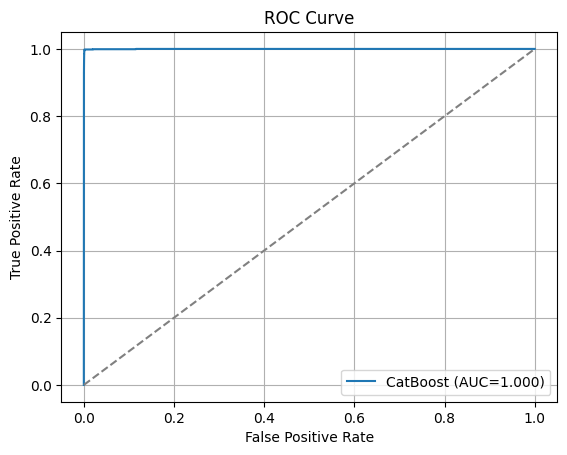

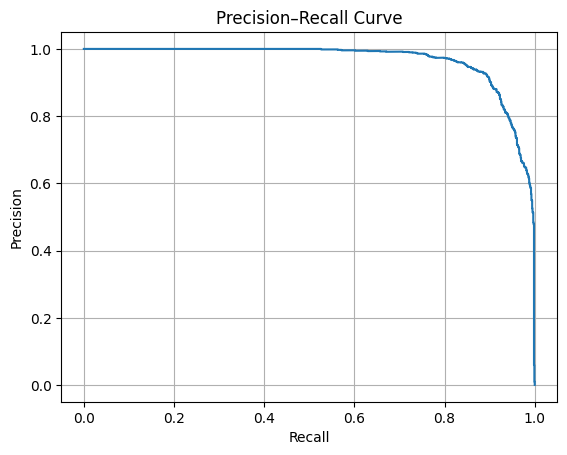

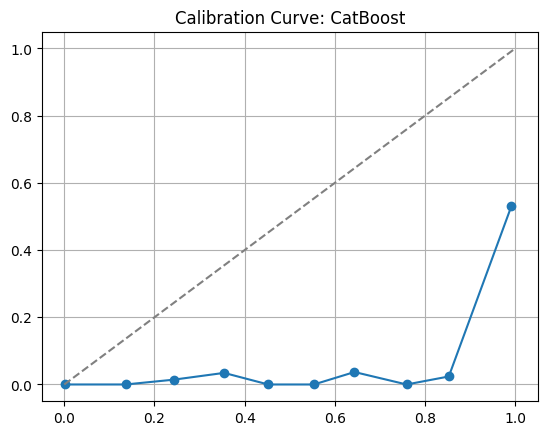

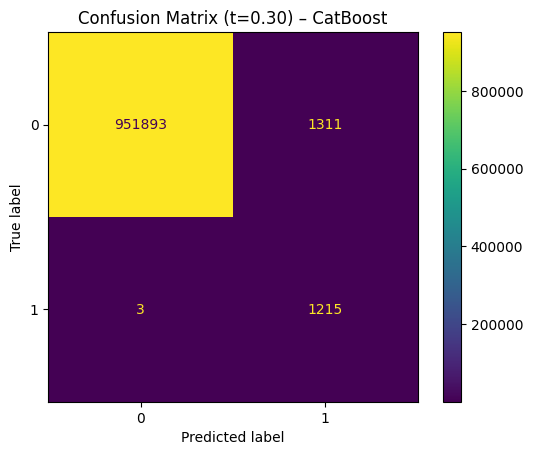

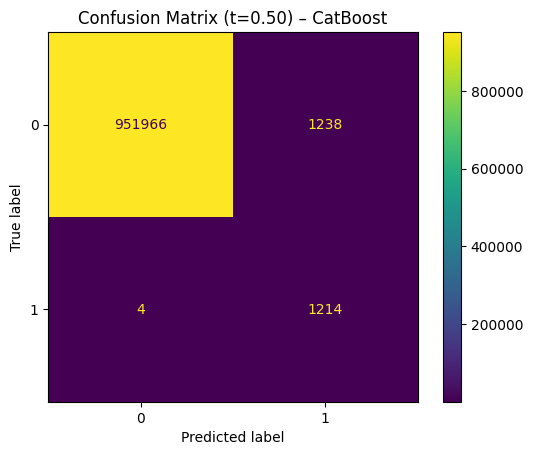

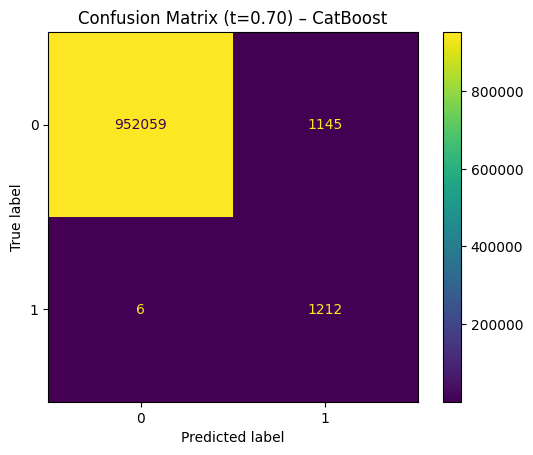

In [56]:
# ==========================================================
# 9. Deeper Evaluation of the Best Model
# ==========================================================
auc = roc_auc_score(y_valid, valid_pred_proba)
ap = average_precision_score(y_valid, valid_pred_proba)
print(f"\nDetailed Evaluation for {best_model_name}:")
print(f"AUC: {auc:.4f}, PR-AUC: {ap:.4f}")

# --- ROC Curve
fpr, tpr, _ = roc_curve(y_valid, valid_pred_proba)
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(); plt.show()

# --- Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_valid, valid_pred_proba)
plt.plot(rec, prec, label=f"{best_model_name}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(); plt.show()

# --- Calibration Curve
prob_true, prob_pred = calibration_curve(y_valid, valid_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--',color='gray')
plt.title(f"Calibration Curve: {best_model_name}"); plt.grid(); plt.show()

# --- Confusion Matrices for multiple thresholds
for t in [0.3, 0.5, 0.7]:
    cm = confusion_matrix(y_valid, (valid_pred_proba >= t).astype(int))
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix (t={t:.2f}) – {best_model_name}")
    plt.show()


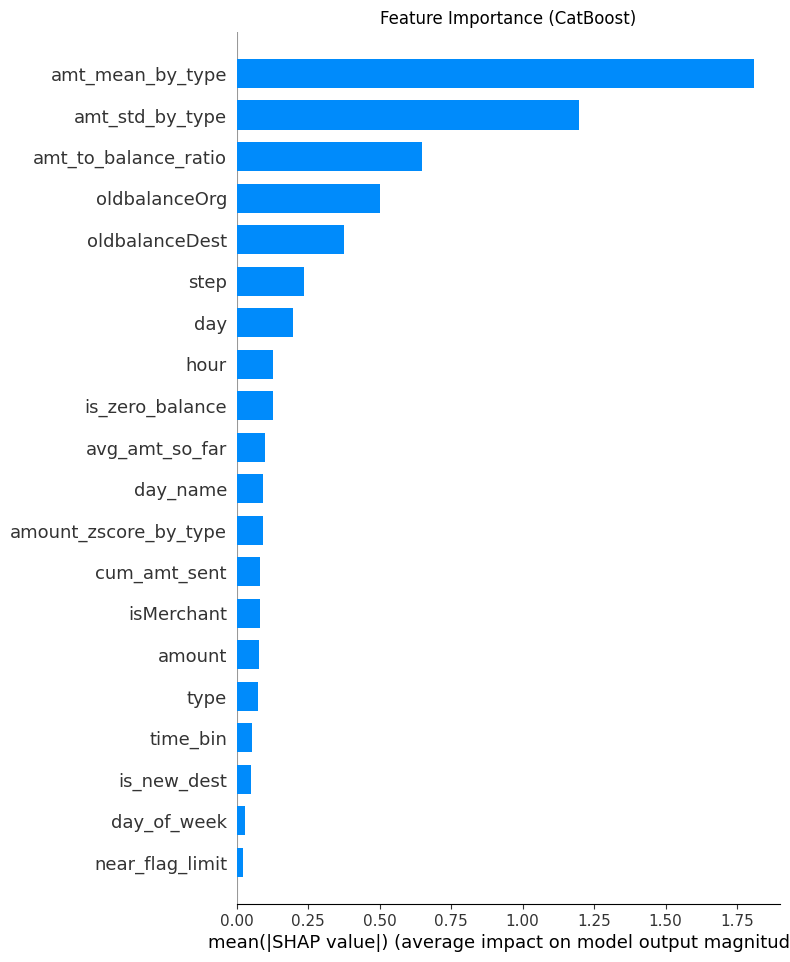

In [57]:
# ==========================================================
# 10. Feature Importance / SHAP for Tree Models
# ==========================================================
if best_model_name in ["CatBoost", "XGBoost", "LightGBM-Safe", "LightGBM-Strict"]:
    explainer = shap.TreeExplainer(best_model)
    sample_idx = np.random.choice(len(X_valid), 1000, replace=False)
    sv = explainer.shap_values(X_valid.iloc[sample_idx])
    shap.summary_plot(sv, X_valid.iloc[sample_idx], plot_type='bar', show=False)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.show()

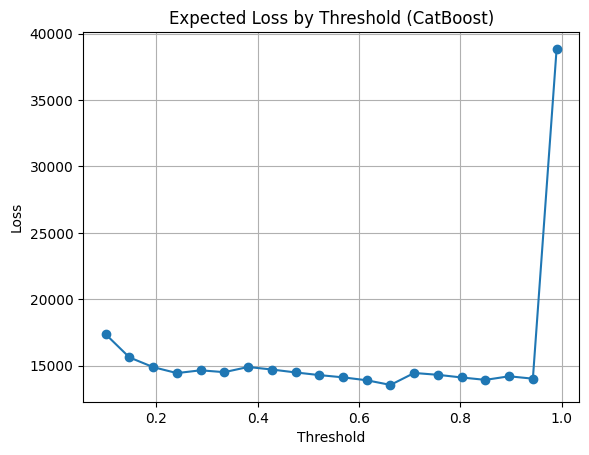

Optimal threshold minimizing cost: 0.662


In [59]:
# ==========================================================
# 11. Cost–Benefit Threshold Optimization
# ==========================================================
cost_fp, cost_fn = 10, 500
def expected_loss(thr):
    yp = (valid_pred_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_valid, yp).ravel()
    return cost_fp*fp + cost_fn*fn

thr_range = np.linspace(0.1, 0.99, 20)
loss_vals = [expected_loss(t) for t in thr_range]
plt.plot(thr_range, loss_vals, marker='o'); plt.title(f"Expected Loss by Threshold ({best_model_name})")
plt.xlabel("Threshold"); plt.ylabel("Loss"); plt.grid(); plt.show()
opt_thr = thr_range[np.argmin(loss_vals)]
print(f"Optimal threshold minimizing cost: {opt_thr:.3f}")

In [ ]:
# ==========================================================
# 12. Model Validation – Next Steps (Actionable)
# ==========================================================

print("\n==========================================================")
print("STEP 12: Model Validation – Recommended Next Actions")
print("==========================================================")

# --- Temporal generalization test
# Hold out the most recent 10% of steps and check performance drop
recent_cutoff = np.quantile(data['step'], 0.90)
mask_recent = data['step'] > recent_cutoff
X_recent = data.loc[mask_recent, feature_cols]
y_recent = data.loc[mask_recent, TARGET]
pred_recent = cb.predict_proba(X_recent)[:, 1]
auc_recent = roc_auc_score(y_recent, pred_recent)
print(f"Temporal Generalization AUC (last 10% of data): {auc_recent:.4f}")

# --- Transaction-type holdout test
for tx_type in data['type'].unique():
    mask = data['type'] == tx_type
    X_sub, y_sub = data.loc[mask, feature_cols], data.loc[mask, TARGET]
    pred_sub = cb.predict_proba(X_sub)[:, 1]
    auc_sub = roc_auc_score(y_sub, pred_sub)
    print(f"AUC on holdout transaction type '{tx_type}': {auc_sub:.4f}")

# --- Calibration sanity check
prob_true, prob_pred = calibration_curve(y_valid, valid_pred_proba, n_bins=10)
miscalibration = np.mean(np.abs(prob_true - prob_pred))
print(f"Average calibration deviation: {miscalibration:.4f}")
if miscalibration > 0.05:
    print("→ Recommendation: Apply Platt scaling or Isotonic Regression calibration.")
else:
    print("→ Calibration looks acceptable.")

# --- Threshold tuning summary
print(f"Recommended operating threshold (min cost): {opt_thr:.3f}")
print("→ Validate this threshold with business owners or fraud analysts to align on cost tradeoffs.")

# --- Monitoring plan (template)
print("""
Monitoring plan for deployment:
  - Track daily AUC / PR-AUC drift between training and live data
  - Log alert counts vs. confirmed fraud cases
  - Re-train monthly or when AUC drops > 5%
  - Monitor class imbalance shifts (fraud ratio) using PSI or KL divergence
""")

# --- Next research actions
print("""
Next research directions:
  • Test model interpretability – examine SHAP at account or transaction-level.
  • Incorporate graph or sequence features (e.g. sender-recipient networks, time gaps).
  • Evaluate model fairness: false-positive rate across transaction sizes and types.
  • Prepare reproducible training pipeline (versioned preprocessing + model weights).
""")


STEP 12: Model Validation – Recommended Next Actions
Temporal Generalization AUC (last 10% of data): 0.9999
AUC on holdout transaction type 'CASH_OUT': 0.9997


c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


AUC on holdout transaction type 'PAYMENT': nan


c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


AUC on holdout transaction type 'CASH_IN': nan
AUC on holdout transaction type 'TRANSFER': 1.0000
AUC on holdout transaction type 'DEBIT': nan
Average calibration deviation: 0.4347
→ Recommendation: Apply Platt scaling or Isotonic Regression calibration.
Recommended operating threshold (min cost): 0.662
→ Validate this threshold with business owners or fraud analysts to align on cost tradeoffs.

Monitoring plan for deployment:
  - Track daily AUC / PR-AUC drift between training and live data
  - Log alert counts vs. confirmed fraud cases
  - Re-train monthly or when AUC drops > 5%
  - Monitor class imbalance shifts (fraud ratio) using PSI or KL divergence


Next research directions:
  • Test model interpretability – examine SHAP at account or transaction-level.
  • Incorporate graph or sequence features (e.g. sender-recipient networks, time gaps).
  • Evaluate model fairness: false-positive rate across transaction sizes and types.
  • Prepare reproducible training pipeline (versioned p

c:\Users\Kwek Jie Han\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
